In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from single_eQIF_utils import *

### Hysteresis heatmap in (a , $I_{ext}$) plane

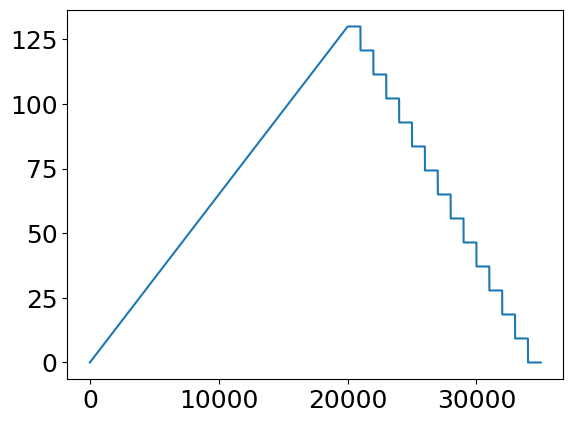

In [ ]:
# Define parameter ranges for hysteresis boundaries
range_hysteresis = 50
a_range_boundaries = np.round(np.linspace(1, 20, range_hysteresis),3) 
Iext_range_boundaries = np.round(np.linspace(0, 130, range_hysteresis),3)

# Define time array for hysteresis boundaries (NOTE: they have to be given in milliseconds)
dt = 0.01
up_time_max = 20000
step_time = 1000
duration_boundaries = up_time_max + step_time*len(Iext_range_boundaries)
time_array_boundaries = np.arange(0, duration_boundaries + dt/2, dt)

# Generate I_steps to find hysteresis boundaries for different a values
I_steps = np.zeros(len(time_array_boundaries))
up_time = (time_array_boundaries <= up_time_max)
I_steps[up_time] = Iext_range_boundaries[-1]*time_array_boundaries[up_time]/up_time_max
down_time = (time_array_boundaries > up_time_max)
I_steps[down_time] = np.concatenate([i_value*np.ones(int(step_time/dt)) for i_value in Iext_range_boundaries[::-1]])
plt.plot(time_array_boundaries, I_steps)
plt.show()

In [17]:
# Find hysteresis boundaries for different a values
start_boundary, stop_boundary = hysteresis_boundaries_Iext_vs_a(time_array_boundaries, a_range_boundaries, b_value=50, I_stim=I_steps, v0=-25, Iw0=500)

In [18]:
# Stop boundary may result in duplicate x-values due to the nature of the hysteresis curve, which can cause issues with spline interpolation. 
# This effect can be smoothed by aggregating duplicate x-values before applying the spline.

# Smooth stop_boundary by aggregating duplicate x-values before spline
x = stop_boundary[:, 0]
y = stop_boundary[:, 1]

# Aggregate duplicate x values by averaging corresponding y values
ux, inv = np.unique(x, return_inverse=True)
y_agg = np.array([y[inv == i].mean() for i in range(len(ux))])

# Choose spline degree safely: k <= len(ux)-1 and at least 1 when possible
k = min(3, max(1, len(ux) - 1))

if len(ux) < 2:
    # Not enough distinct points to interpolate: plot raw points
    raise ValueError("Not enough distinct points to interpolate")
else:
    xnew = np.linspace(ux[0], ux[-1], 500)
    try:
        spl = make_interp_spline(ux, y_agg, k=k)
        power_smooth = spl(xnew)
    except Exception:
        # Fallback to linear interpolation if spline fails
        power_smooth = np.interp(xnew, ux, y_agg)

In [ ]:
# Define parameters grid for frequency heatmap to superimpose on hysteresis boundaries
# NOTE: parameters range can be different from the one used to find hysteresis boundaries, 
# but it should cover the same area of the parameter space to be able to superimpose the results.
# It was done since the frequency heatmap is more computationally expensive, so we can use a coarser grid for it.
range_heatmap = 70
a_range_heatmap = np.round(np.linspace(1, 20, range_heatmap),3) 
Iext_range_heatmap = np.round(np.linspace(0, 130, 60),3)
parameters_grid_v2 = [(a, I) for a in a_range_heatmap for I in Iext_range_heatmap]
I_vs_a_results = {}

# (NOTE: they have to be given in milliseconds)
dt = 0.01
duration = 20000
t_start = duration - 4000
t_end = duration - 1000
time_array = np.arange(0, duration + dt/2, dt)

for i, (a_val, i_val) in enumerate(parameters_grid_v2):
    I_injected = np.ones(len(time_array))*i_val
    
    V_sim, Iw_sim, spikes_sim = variable_current_sim(time_array, I_injected, a_val, b=50, v0=-25, Iw0=500)
    
    avg_f = compute_rate(spikes_sim, t_start, t_end)
    I_vs_a_results[(a_val, i_val)] = avg_f

avg_frequencies = []

for (a_val, i_val) in parameters_grid_v2:
    f_value = I_vs_a_results[(a_val, i_val)]
    avg_frequencies.append(f_value)
avg_frequencies = np.array(avg_frequencies).reshape(len(a_range_heatmap), len(Iext_range_heatmap))

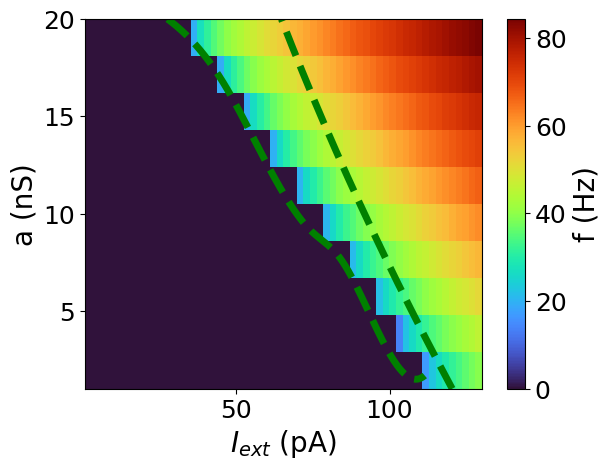

In [20]:
# Plot the results with custom font sizes for better readability
plt.rcParams.update({
'font.size': 20,          # Controls default text size
'axes.titlesize': 20,     # Title font size
'axes.labelsize': 20,     # X/Y label font size
'xtick.labelsize': 18,    # X tick labels
'ytick.labelsize': 18,    # Y tick labels
'legend.fontsize': 14,    # Legend font size
})

# Overlay original points lightly
#plt.plot(stop_boundary[:, 0], stop_boundary[:, 1], 'g', lw=2, alpha=0.5)
plt.plot(xnew, power_smooth, '--g', lw=5)
plt.plot(start_boundary[:, 0], start_boundary[:, 1], '--g', lw=5)
plt.imshow(avg_frequencies, origin='lower', cmap='turbo', extent=(1, Iext_range_heatmap[-1], a_range_heatmap[0], a_range_heatmap[-1]), aspect='auto')
plt.colorbar(label='f (Hz)')
plt.xlim(1, 130)
plt.xlabel(r'$I_{ext}$ (pA)')
plt.ylabel('a (nS)')
plt.show()

### Plot hysteresis frequency heatmap for different b values 

In [ ]:
# Define simulation parameters for frequency heatmap (NOTE: times have to be given in milliseconds)
duration = 25000  
dt = 0.01  
# Define window to compute frequency (NOTE: it has to be given in milliseconds)
t_start = duration - 4000
t_end = duration - 1000
time_array = np.arange(0, duration + dt/2, dt)

Iext_range = np.round(np.linspace(50, 200, 10),2)
b_range = np.round(np.linspace(0, 150, 10),2)

# Compute frequency heatmap for different Iext and b values, keeping a fixed 
output_frequency = []

for Iext in Iext_range:
    freqs = []
    for b_val in b_range:
        V_sim, Iw_sim, spikes_sim = variable_current_sim(time_array, np.ones(len(time_array))*Iext, a=10., b=b_val, v0=-25, Iw0=100)

        f_sim = compute_rate(spikes_sim, t_start, t_end)
        freqs.append(f_sim)
    output_frequency.extend(freqs)
output_frequency = np.array(output_frequency).reshape(len(Iext_range), len(b_range))

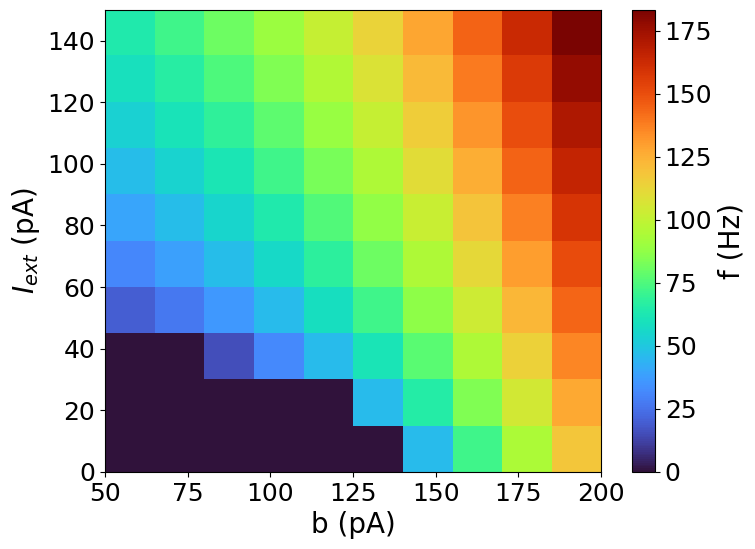

In [5]:
# Plot the results with custom font sizes for better readability
plt.rcParams.update({
'font.size': 20,          # Controls default text size
'axes.titlesize': 20,     # Title font size
'axes.labelsize': 20,     # X/Y label font size
'xtick.labelsize': 18,    # X tick labels
'ytick.labelsize': 18,    # Y tick labels
'legend.fontsize': 14,    # Legend font size
})

plt.figure(figsize=(8, 6))

plt.imshow(output_frequency, origin='lower', cmap='turbo', extent=(Iext_range[0], Iext_range[-1], b_range[0], b_range[-1]), aspect='auto')
plt.colorbar(label='f (Hz)')
plt.xlabel('b (pA)')
plt.ylabel('$I_{ext}$ (pA)')
plt.show()

### Plot hysteresis loop

In [ ]:
# Define time parameters for simulations and analysis
# (NOTE: they have to be given in milliseconds)
dt = 0.01
duration = 25000
time_array = np.arange(0, duration + dt/2, dt)
t_start = duration - 5000
t_end = duration - 1000

# Simulate with different Iext value to show the hysteresis effect in the frequency response of the neuron
# Changing initial conditions to show the hysteresis effect in the frequency response of the neuron
Iext_range = np.round(np.linspace(30, 100, 150),2)

up_frequency = []
down_frequency = []

for Iext in Iext_range:
    V_sim_up, Iw_sim_up, spikes_sim_up = variable_current_sim(time_array, np.ones(len(time_array))*Iext, a=10, b=100, v0=-25, Iw0=100)
    V_sim_down, Iw_sim_down, spikes_sim_down = variable_current_sim(time_array, np.ones(len(time_array))*Iext, a=10, b=100, v0=-25, Iw0=-100)

    f_up = compute_rate(spikes_sim_up, t_start, t_end)
    f_down = compute_rate(spikes_sim_down, t_start, t_end)

    up_frequency.append(f_up)
    down_frequency.append(f_down)

up_frequency = np.array(up_frequency)
down_frequency = np.array(down_frequency)

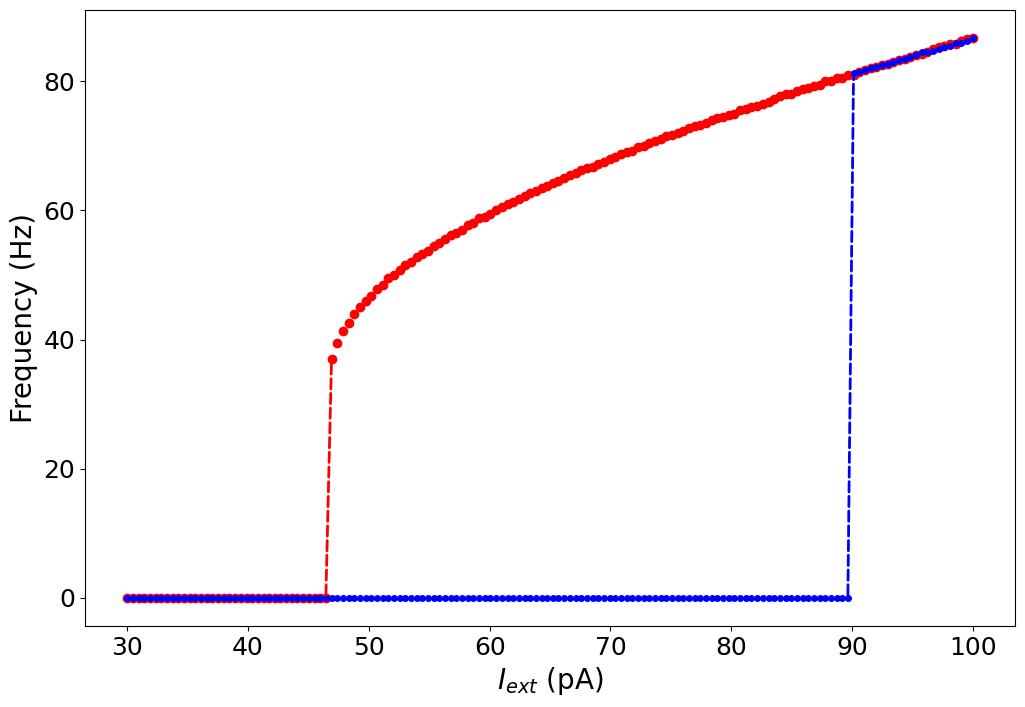

In [11]:
# Plot the results with custom font sizes for better readability
plt.rcParams.update({
'font.size': 20,          # Controls default text size
'axes.titlesize': 20,     # Title font size
'axes.labelsize': 20,     # X/Y label font size
'xtick.labelsize': 18,    # X tick labels
'ytick.labelsize': 18,    # Y tick labels
'legend.fontsize': 14,    # Legend font size
})

plt.figure(figsize=(12, 8))
plt.plot(Iext_range, up_frequency, 'or', markersize=6)
plt.plot(Iext_range, down_frequency, 'ob', markersize=4)

# Define arrow to show jump from 0 to >0 for the ascending curve
threshold = 0.1  
for i in range(len(up_frequency)-1):
    if up_frequency[i] < threshold and up_frequency[i+1] > threshold:
        plt.annotate('', xy=(Iext_range[i+1], up_frequency[i+1]),
                    xytext=(Iext_range[i], up_frequency[i]),
                    arrowprops=dict(arrowstyle='-', color='red', lw=2, linestyle='--'))
        break

# Define arrow to show jump from >0 to 0 for the descending curve
for i in range(len(down_frequency)-1):
    if down_frequency[i] < threshold and down_frequency[i+1] > threshold:
        plt.annotate('', xy=(Iext_range[i+1], down_frequency[i+1]),
                    xytext=(Iext_range[i], down_frequency[i]),
                    arrowprops=dict(arrowstyle='-', color='blue', lw=2, linestyle='--'))
        break

plt.xlabel('$I_{ext}$ (pA)')
plt.ylabel('Frequency (Hz)')
plt.show()